# Risk parity on two assets, 南华商品，中债净价(3-5年)
- 风险平价策略: 对组合中不同资产分配相同的风险权重的一种投资策略

> 风险平价（Risk Parity）策略通过平衡分配不同资产类别在组合风险中的贡献度，实现了投资组合的风险结构优化。通过风险平价配置，投资组合不会暴露在单一资产类别的风险敞口中，因而可以在风险平衡的基础上实现理想的投资收益。

- 风险平价策略应用于大类资产配置

本报告将同时对债券和大宗商品两个资产组合，运用以下策略进行对比
>- 等权重策略
>- 最小方差策略
>- 简单风险平价策略及
>- 优化风险平价策略。

等权重组合的年化收益率为 1.77%，年化波动率为 0.07，夏普比 率为0.25，最大回撤为29.09%；最小方差组合的年化收益率为-0.35%，年化波动率为0.01， 夏普比率为 -0.26，最大回撤为 8.32%；简单风险平价组合的年化收益率为 -0.34%，年化波动率为 0.02，夏普比率为 -0.20，最大回撤为 8.35%；最优风险平价组合的年化收益率为 1.04%， 年化波动率为 0.05，夏普比率为 0.19，最大回撤为 19.31%。

策略的具体实施:
为对比资产配置效果，本次对标的资产组合处理如下： 
>- 对各策略进行滚动测试，每3个月进行仓位调整
>- 自 2008 年 8 月起对标的组合进行测试，选取半年作为样本期，滚动计算样本期内组合的协方差矩阵以作为下一期协方差矩阵的估计
>- 将所得的协方差矩阵作为模型参数，求解未来下一月的持仓权重；

### 1. import modules

In [2]:
import pandas as pd
import numpy as np
import os
np.random.seed(1000)
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
import time
import scipy.stats as stats
from scipy.optimize import minimize
import scipy.optimize as sco
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as sch
from datetime import date
from sklearn.externals import joblib
from sklearn.covariance import shrunk_covariance, ledoit_wolf, OAS, MinCovDet
from copy import copy
from tqdm import tqdm

/home/weiwu/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 2. get data

In [3]:
data = pd.read_csv('./assets.csv', index_col='Date', parse_dates=True).rename(
    columns={"CBA00332.CS":"Bond","NH0100.NHF":"Commodity","000300.SH":"Equity"})
data.head()

,Bond,Commodity,Equity
Date,,,
2008-08-21,112.6504,1329.2136,2443.979
2008-08-22,112.6684,1339.8214,2404.928
2008-08-25,112.7239,1338.8501,2400.548
2008-08-26,112.7656,1320.3190,2331.532
2008-08-27,112.8205,1338.8923,2325.292


### ticker selection and lookback input

In [4]:
tickers = ['Bond', 'Commodity'] 

df_returns = data[tickers].pct_change().dropna()
df_returns.head()

,Bond,Commodity
Date,,
2008-08-22,0.000160,0.007981
2008-08-25,0.000493,-0.000725
2008-08-26,0.000370,-0.013841
2008-08-27,0.000487,0.014067
2008-08-28,0.000909,-0.003474


### visualize normalized index with start value of 100

/home/weiwu/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


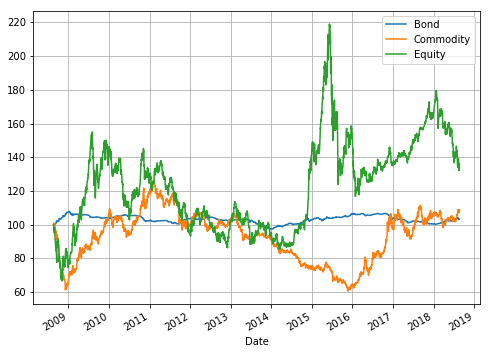

In [5]:
(data / data.ix[0] * 100).plot(figsize=(8, 6), grid=True)
# tag: real_returns_1
# title: Evolution of index levels over time

### 3. transform data, print statistics of return, normality test

In [6]:
def print_statistics(array):
    ''' Prints selected statistics.
    
    Parameters
    -------------
    array: ndarray
        object to generate statistics on
    '''
    sta = scs.describe(array)
    print ("%14s %15s" % ('statistic', 'value'))
    print (30 * "-")
    print ("%14s %15.5f" % ('size', sta[0]))
    print ("%14s %15.5f" % ('min', sta[1][0]))
    print ("%14s %15.5f" % ('max', sta[1][1]))
    print ("%14s %15.5f" % ('mean', sta[2]))
    print ("%14s %15.5f" % ('std', np.sqrt(sta[3])))
    print ("%14s %15.5f" % ('skew', sta[4]))
    print ("%14s %15.5f" % ('kurtosis', sta[5]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52db0b6e10>,
      dtype=object)

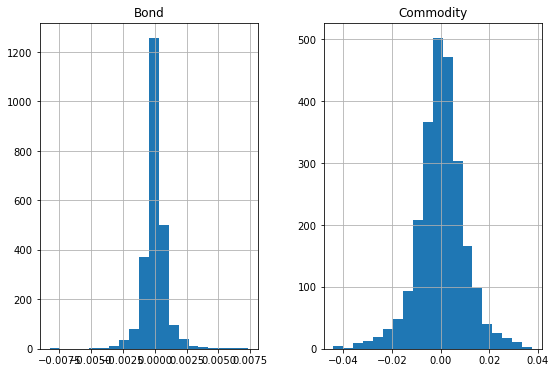

In [7]:
df_returns[tickers].hist(bins=20, figsize=(9, 6))
# tag: real_returns_2
# title: Histogram of respective log-returns
# size: 90

In [8]:
for sym in tickers:
    print("\nResults for symbol %s" % sym)
    print(30 * "-")
    print_statistics(df_returns[sym].values)


Results for symbol Bond
------------------------------
     statistic           value
------------------------------
          size      2432.00000
           min        -0.00825
           max         0.00733
          mean         0.00001
           std         0.00096
          skew         0.39803
      kurtosis        12.73785

Results for symbol Commodity
------------------------------
     statistic           value
------------------------------
          size      2432.00000
           min        -0.04408
           max         0.03754
          mean         0.00008
           std         0.00982
          skew        -0.19705
      kurtosis         1.87093


#### 注意到两类标的百分比skewness均不接近0, 非正态分布。

#### 资产相关性

In [9]:
df_returns[tickers].corr()

,Bond,Commodity
Bond,1.000000,-0.086353
Commodity,-0.086353,1.000000


相关性上，在08年至18年过去10年间，债券和商品相关性不强。

### 4. portfolio weight calculation
### 4.1 function definition

In [10]:
def to_percent(x):
    try: f_string = '{:.2%}'.format(x)
    except: f_string = x
    return f_string

def to_decimal(x):
    try:
        if x >= 100:
            f_string = '{0:,.0f}'.format(x)
        elif x >= 10:
            f_string = '{0:,.1f}'.format(x)
        else:
            f_string = '{0:,.2f}'.format(x)
            
    except: f_string = x
    return f_string

def annual_volatility(df_single_returns):
    """
    Determines the annual volatility of a strategy.

    Parameters
    ----------
    df_single_returns : pd.Series or np.ndarray
        Periodic returns of the strategy, noncumulative.

    Returns
    -------
    float, np.ndarray
        Annual volatility.
    """

    if len(df_single_returns) < 2:
        return np.nan

    std = df_single_returns.std(ddof=1)

    volatility = std * (252 ** (1.0 / 2))

    return volatility.astype(np.float)

def max_drawdown(df_returns):
    max_dd = (np.cumprod(1+df_returns)/np.maximum.accumulate(np.cumprod(1+df_returns))-1).min()
    return max_dd
def cal_max_dd(df_single_return):
    """
    Determines the maximum drawdown of a strategy.

    Parameters
    ----------
    df_single_return :
        Daily returns of the strategy, noncumulative.

    Returns
    ----------
    float
        Maximum drawdown.
    """
    if len(df_single_return) < 1:
        return np.nan

    df_perform_equity_curve = (1. + df_single_return).cumprod()
    df_perform_cum_max = df_perform_equity_curve.cummax()
    # drawdown series
    df_perform_drawdown = df_perform_equity_curve / df_perform_cum_max - 1
    max_dd = df_perform_drawdown.min()
    return max_dd

def annual_return(df_single_return, period):
    """Determines the mean annual growth rate of returns.

    Parameters
    ----------
    df_single_return : pd.Series or np.ndarray
        Periodic returns of the strategy, noncumulative.
    period : str, optional
        Defines the periodicity of the 'returns' data for purposes of
        annualizing. Value ignored if `annualization` parameter is specified.
        Defaults are:
            'monthly':12
            'weekly': 52
            'daily': 252

    Returns
    -------
    float
    """

    if len(df_single_return) < 1:
        return np.nan

    num_years = float(len(df_single_return)) / period

    # Pass array to ensure index -1 looks up successfully.
    df_cum = (df_single_return + 1).cumprod(axis=0) - 1
    f_annual_return = (1. + df_cum.iloc[-1,:]) ** (1. / num_years) - 1

    return f_annual_return.apply(to_percent)

def to_summary(df_returns):
    # Daily return calcs
    df_summary = pd.DataFrame(columns=df_returns.columns)
    df_summary.loc['Summary Stats:'] = ''
    MOIC = np.prod(1+df_returns)
    CAGR = MOIC**(periodicity/len(df_returns))-1
    df_summary.loc['Annualized Return'] = annual_return(df_returns, 252)
    df_summary.loc['Sharpe'] = CAGR/(np.std(df_returns)*np.sqrt(periodicity))
    df_summary.loc['Volatility'] = annual_volatility(df_returns)    
    df_summary.loc['Sortino'] = CAGR/(np.std(np.clip(df_returns, a_max=0, a_min=None))*np.sqrt(periodicity))
    df_summary.loc['Max Drawdown'] = cal_max_dd(df_returns).apply(to_percent)  
    df_summary = df_summary.applymap(to_decimal)
    
    # Monthly return calcs
    df_summary.loc['Monthly Perf. Metrics:'] = ''
    df_months = pd.DataFrame(columns=df_returns.columns)
    df_returnsM = (1+df_returns).resample('M').prod()-1
    MOIC_M = np.prod(1+df_returnsM)
    CAGR_M = MOIC_M**(12/len(df_returnsM))-1
    df_months.loc['Sharpe'] = CAGR_M/(np.std(df_returnsM)*np.sqrt(12))
    df_months.loc['Sortino'] = CAGR_M/(np.std(np.clip(df_returnsM, a_max=0, a_min=None))*np.sqrt(12))
    
    if len(df_returnsM) >= 36: df_months.loc['Calmar'] = -(np.prod(1+df_returnsM.iloc[-12*3:])**(1/3)-1)\
                                                         / max_drawdown(df_returnsM.iloc[-12*3:])
    
    df_months = df_months.applymap(to_decimal)
    df_summary = df_summary.append(df_months)
    
    # Annuals
    df_summary.loc['Annual Returns:'] = ''
    df_annuals = df_returns.groupby(df_returns.index.year).apply(lambda x: np.prod(1+x)-1).applymap(to_percent)
    df_summary = df_summary.append(df_annuals)

    # Drawdowns
    df_summary.loc['Annual Max DD:'] = ''    
    df_maxdd = df_returns.groupby(df_returns.index.year).apply(cal_max_dd).applymap(to_percent)
    df_summary = df_summary.append(df_maxdd)
    return df_summary

### 4.2 Simple Risk Parity
简单风险均衡假设资产之间没有相关性

In [11]:
lookback = 21*6
corr_lookback = 21*24
periodicity = 252

n_tickers = len(tickers)
N = len(data)
resample_freq = '3M'

In [12]:
#-------------------------------------
# Weighted arrays
#-------------------------------------
syd_array = np.arange(1, lookback+1)/np.arange(1, lookback+1).sum()
syd_array = syd_array.reshape(-1, 1)
log_array = np.log(np.arange(lookback)+1)/np.log(np.arange(lookback)+1).sum()
log_array = log_array.reshape(-1, 1)
sqrt_array = np.sqrt(np.arange(lookback)+1)/np.sqrt(np.arange(lookback)+1).sum()
sqrt_array = sqrt_array.reshape(-1, 1)

In [14]:
# Simple risk parity weight calc
t1 = time.time()
df_returns = data[tickers].pct_change()
short_asset = ''
if short_asset in df_returns.columns:
    df_returns[short_asset] *= -1               

df_RV = np.sqrt(periodicity/lookback*(np.log(1+df_returns)**2).rolling(lookback).sum())*100
arr_IV = np.array(1/df_RV)
IV_wt_arr = arr_IV/arr_IV.sum(axis=1).reshape(-1, 1)
df_IV_weights = pd.DataFrame(index=df_RV.index, columns=df_RV.columns, data=IV_wt_arr)

if short_asset in df_returns.columns:
    df_returns[short_asset] *= -1               
    df_IV_weights[short_asset] *= -1

IV_returns = (df_IV_weights.resample(resample_freq).first().asfreq('D', method='ffill').shift(1)*df_returns[tickers]).sum(axis=1)
print("{0:,.5f}".format(time.time()-t1), 'seconds')
df_returns['RP'] = IV_returns
df_IV_weights.tail(1)

0.05873 seconds


,Bond,Commodity
Date,,
2018-08-21,0.87518,0.12482


### 4.3 Equal Risk Contribution

In [18]:
# Calculate ERC risk parity weights
def get_F(omega, y):
    x = y[:-1]
    newt_lambda = y[-1]
    F = np.zeros([len(x)+1, 1])
    F[:-1] = omega @ x - (newt_lambda*(1/x))
    F[-1] = x.sum()-1
    return F

def get_J(omega, y):
    x = y[:-1]
    newt_lambda = y[-1]
    J = np.zeros([len(x)+1, len(x)+1])
    J[:-1, :-1] = omega + newt_lambda*np.diagflat(1/np.square(x))
    J[:-1, -1] = -1/x.ravel()
    J[-1, :-1] = 1
    return J

def getERCWeights(omega, y, epsilon):
    y_last = y
    y_next = y_last - (np.linalg.inv(get_J(omega, y_last)) @ get_F(omega, y_last))
    condition = np.linalg.norm(y_next - y_last, ord=2)
    
    while condition > epsilon:
        y_last = y_next
        y_next = y_last - (np.linalg.inv(get_J(omega, y_last)) @ get_F(omega, y_last))
        condition = np.linalg.norm(y_next - y_last, ord=2)
    
    return y_next[:-1]

newt_lambda0 = 0.5
eps = 10**-8
x0 = np.ones([n_tickers, 1])/n_tickers
y0 = np.append(x0, newt_lambda0).reshape(n_tickers+1, 1)

returns_array = np.array(df_returns[tickers])

ERC_wts_arr = np.zeros(returns_array.shape) + 1/n_tickers

for i in tqdm(range(corr_lookback, N)): 
    returns_array_corr = returns_array[i-corr_lookback+1:i+1, :]
    returns_array_cov  = returns_array[i-lookback+1:i+1, :]
    
    corr = np.corrcoef(returns_array_corr.T)
    cov_diag = np.diag(np.sqrt(np.var(returns_array_cov, axis=0)))
    omega = cov_diag @ corr @ cov_diag
    omega = shrunk_covariance(omega, shrinkage=0.05)*10**4
    ERC_wts_arr[i] = getERCWeights(omega, y0, eps).T
    
df_ERC_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns[:len(tickers)], data=ERC_wts_arr)

100%|██████████| 1929/1929 [00:04<00:00, 431.63it/s]


,Bond,Commodity
Date,,
2018-08-21,0.824259,0.175741


In [114]:
ERC_returns = (df_ERC_weights.resample(resample_freq).first().asfreq('D', method='ffill').shift(1)*df_returns[tickers]).sum(axis=1)
df_ERC_weights.tail(1)

,Bond,Commodity
Date,,
2018-08-21,0.824259,0.175741


In [115]:
df_returns['ERC'] = ERC_returns

### 4.4 Equally weighted portfolio

In [104]:
df_ew_weights = copy(data[tickers].iloc[lookback:])
df_ew_weights[tickers] = 1/n_tickers
ew_returns = (df_ew_weights.resample(resample_freq).first().asfreq('D', method='ffill').shift(1)*df_returns[tickers]).sum(axis=1)

In [105]:
# return on equally weighted
df_returns['EW'] = ew_returns

### 4.5 Minimum variance portfolio

In [22]:
def statistics(weights, iteration):
    ''' Return portfolio statistics.
    
    Parameters
    -------------
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    ------------
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(df_returns[tickers].iloc[df_returns.index.get_loc(iteration)-lookback:df_returns.index.get_loc(iteration),:].mean() * weights) * 252
    #pvol = annual_volatility(df_returns[tickers].loc[iteration]))
    pvol = np.sqrt(np.dot(weights.T, np.dot(df_returns[tickers].iloc[df_returns.index.get_loc(iteration)-lookback:df_returns.index.get_loc(iteration),:].cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [23]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

In [24]:
bnds = tuple((0, 1) for x in range(n_tickers))

In [25]:
def min_func_variance(weights, iteration):
    return statistics(weights, iteration)[1] ** 2

In [26]:
df_mv_weights = copy(data[tickers].iloc[lookback:])
df_mv_weights[tickers]  = 0

In [27]:
for iteration in tqdm(df_returns.iloc[lookback:].index):
    opts = sco.minimize(min_func_variance, n_tickers * [1. / n_tickers,], iteration, method='SLSQP',
                       bounds=bnds, constraints=cons)
    df_mv_weights.loc[iteration] = opts['x']

100%|██████████| 2307/2307 [03:58<00:00, 11.60it/s]


In [106]:
df_mv_returns = (df_mv_weights.resample(resample_freq).first().asfreq('D', method='ffill').shift(1)*df_returns).sum(axis=1)
# return on minimum variance
df_returns['MV'] = df_mv_returns

### 5. Summary

In [116]:
to_summary(df_returns)

,Bond,Commodity,RP,ERC,EW,MV
Summary Stats:,,,,,,
Annualized Return,0.33%,0.87%,-0.34%,1.04%,1.77%,-0.35%
Sharpe,0.22,0.06,-0.20,0.19,0.25,-0.26
Volatility,0.02,0.16,0.02,0.05,0.07,0.01
Sortino,0.36,0.09,-0.32,0.30,0.41,-0.41
Max Drawdown,-9.72%,-51.94%,-8.35%,-19.31%,-29.09%,-8.32%
Monthly Perf. Metrics:,,,,,,
Sharpe,0.13,0.05,-0.15,0.18,0.24,-0.16
Sortino,0.23,0.08,-0.25,0.25,0.45,-0.25
Calmar,-0.07,1.36,0.19,0.54,1.14,-0.04


债券和商品组合，等权重组合的年化收益率为 1.77%，年化波动率为 0.07，夏普比 率为0.25，最大回撤为29.09%；最小方差组合的年化收益率为-0.35%，年化波动率为0.01， 夏普比率为 -0.26，最大回撤为 8.32%；简单风险平价组合的年化收益率为 -0.34%，年化波动率为 0.02，夏普比率为 -0.20，最大回撤为 8.35%；最优风险平价组合的年化收益率为 1.04%， 年化波动率为 0.05，夏普比率为 0.19，最大回撤为 19.31%。

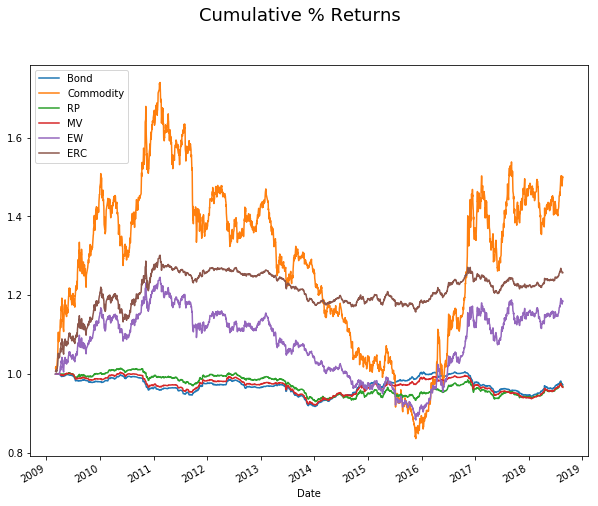

In [90]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 8)
np.cumprod(1+df_returns.iloc[lookback:]).plot()
plt.legend(loc='best')
#plt.yscale('log')
plt.suptitle('Cumulative % Returns', fontsize=18)


等权重策略在资产配置时仅考虑了权重的分散性，而并未考虑资产风险；最小方差组合仅考 虑了资产风险贡献进而使组合风险最小，而未考虑风险的分散性。在此背景下，风险平价策略有效弥补了二者在配置分散化方面的局限。等权组合波动性最大，最优风险平价走势和波动都比较稳，其当前给出的组合权重分别为债券 0.82和商品 0.18。

- 风险平价是一种资金配置方法

按对投资组合风险贡献相等的原则，将资金配置给各类资产。依据所选择的整体风险水平不同，这通常的结果是权益配置较低，而对固定收益资产有杠杆敞口。

- 当前利率趋升的环境给风险平价带来问题 

虽然过去一个世纪央行大放水，押低利率，给债券带来了利好，但是风险平价存在一些令人担忧的问题，在利率上升的情况下，整体表现下滑，当收益率跳升时，风险平价可能会放大固定收益资产的跌幅。在未来十年， 随着美联储撤出量化宽松并进入加息周期，中国央行跟随加息，这可能会导致债券收益率大幅走升，损及有杠杆的固定收益投资组合。

- 改进：

在只有债券和商品两个标的的情况下，我们的组合收益缺少权益类资产带来的增长带动效应，因此在另一篇文章中我将尝试把沪深300纳入组合当中。

因为考虑到当前的经济形式，并将Target Risk 设置在个相应的档位，再加上择时，对风险平价策略会更有帮助。
